# Урок 7. Классификация с помощью kNN. Кластеризация K-means

**План занятия**

* [Теоретическая часть](#theory)
    * [Меры и метрики расстояния между объектами](#metrics)
    * [Алгоритм kNN](#knn)
        * [Реализация алгоритма kNN](#implement_knn)
    * [Обучение без учителя. Кластеризация. K-means](#unsupervised)
        * [Внутренние метрики](#in)
        * [Внешние метрики](#out)
        * [Алгоритм K-means (K-средних)](#kmeans)
* [Домашнее задание](#hw)

## <center>Теоретическая часть<a class="anchor" id="theory"></a><center>

В этом уроке речь пойдет о так называемых *метрических алгоритмах*, то есть об алгоритмах, построенных на вычислении расстояний между объектами. Для начала нам нужно определить, какими способами эти расстояния можно вычислять.

## Меры и метрики расстояния между объектами<a class='anchor' id='metrics'>

Понятие метрических пространств, метрик и некоторые их примеры уже рассматривались вами на курсе по линейной алгебре в рамках обучения по профессии. В этом разделе мы вспомним, какие могут быть метрики и их применение в плоскости машинного обучения.

Метрика является функцией, задающей расстояние в метрическом пространстве. Как мы помним из курса линейной алгебры, она должна удовлетворять трем аксиомам:

1. $\rho(x, y) \geq 0, \rho(x, y) = 0 \Leftrightarrow x = y;$
2. $\rho(x, y) = \rho (y, x);$
3. $\rho(x, y) \leq \rho(x, z) + \rho(z, y).$

Евклидова метрика

$${\rho(x, y) = \sqrt{\sum_{i=1}^{n}(x_{i}-y_{i})^{2}}}$$

и манхэттенская метрика

$$\rho(x, y) = \sum_{i=1}^{n}|x_{i}-y_{i}|$$

уже должны быть вам знакомы. 

<img src='images/euc_manh.jpg'>

Также можно показать обобщение этих двух метрик - метрика Минковского:

$$\rho(x, y) = \left ( \sum_{i=1}^{n}|x_{i}-y_{i}|^{q} \right )^{\frac{1}{q}}.$$

При этом при $q = 1$ получаем манхэттенскую ($L_{1}$) метрику, при $q = 2$ - евклидову ($L_{2}$) метрику.

Кроме этого, в метрических алгоритмах часто используются так называемые меры близости. В отличие от метрик, которые тем меньше, чем объекты более похожи, меры близости увеличиваются при увеличении похожести (близости) объектов.

Примером такой функции может быть *косинусное сходство (косинусная мера)*:

$$\text{cos}\theta = \frac{\left \langle x, y \right \rangle}{||x||\cdot||y||} = \frac{\sum_{i=1}^{n}x_{i}y_{i}}{\sqrt{\sum_{i=1}^{n}x_{i}^{2}}\sqrt{\sum_{i=1}^{n}y_{i}^{2}}}.$$

Из этой функции также вытекает *косинусное расстояние*:

$$\rho_{cos}(x, y) = 1 - \text{cos}\theta = 1 - \frac{\sum_{i=1}^{n}x_{i}y_{i}}{\sqrt{\sum_{i=1}^{n}x_{i}^{2}}\sqrt{\sum_{i=1}^{n}y_{i}^{2}}}.$$

Именно такая формула используется в функции `scipy.spatial.distance.cosine()` из библиотеки scipy, возвращающая косинусное расстояние между двумя векторами.

<img src='images/trig.png'>

__Аналитический смысл__: объекты представлены в виде векторов, между двумя векторами образуется угол, значение косинуса этого угла – это и есть косинусная мера (следует из формулы скалярного произведения). 

Косинусная мера часто используется в анализе текстов.

<img src='images/cosine.png'>


__Почему эта функция - метрика?__

* f(x, x) = 0 - потому что cos(0)=1
* f(x,y) = f(y,x) - по симметрии - очевидно, что угол между x и y равен углу между y и x
* неравенство треугольника (физический смысл)

Кроме косинусной меры в прикладных задачах могут использоваться и другие функции - коэффициент Дайса, коэффициент Жаккара, коэффициент перекрытия (см. доп. материалы).

## Алгоритм kNN<a class='anchor' id='knn'>

Начнем обсуждение метрических алгоритмов с алгоритма kNN. Данный алгоритм является еще одним способом решения задачи классификации. Расшифровывается его название как "k ближайших соседей (k nearest neighbours)".

Суть его довольно проста и заключается в принципе отнесения объекту к тому классу, представители которого преобладают рядом с ним. Таким образом, упрощенно алгоритм классификации выглядит следующим образом:

- найти расстояние от объекта $u$ до каждого из объектов $x$ обучающей выборки;
- выбрать $k$ объектов, расстояние до которых минимально;
- отнести объект к классу, к которому относится большинство из выбранных $k$ ближайших соседей, то есть провести голосование.

При этом метод можно адаптировать под регрессию: в этом случае находится не метка класса, а среднее значение ответа среди $k$ соседей.

<img src='images/knn.png' width=600px>

Интересной особенностью метода является то, что на этапе обучения не строится модель, а просто запоминается обучающая выборка. Вычисления начинаются именно на этапе решения задачи классификации конкретного объекта (поэтому этот алгоритм можно назвать ленивым).

Логичным усовершенствованием алгоритма kNN является добавление соседям весов (так называемое "взвешенное голосование"), зависящих от их порядкового номера или расстояния до классифицируемого объекта (чем ближе объект обучающей выборки, тем больше его вес).

<img src='images/knn_weighted.png' width=550px>

**От номера соседа $i$ веса можно определять как:**

### - $w(i) = q^{i}$,   $q \in (0,1)$;

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

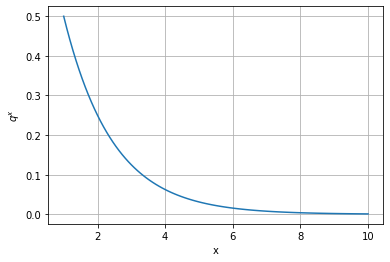

In [2]:
dots = np.linspace(1, 10, 100)
q = 0.5
value = list(map(lambda x: q ** x, dots))

plt.xlabel('x')
plt.ylabel('$q^x$')
plt.grid()
plt.plot(dots, value);

### - $w(i) = \frac{1}{i}$;

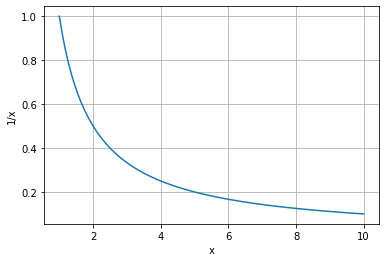

In [3]:
dots = np.linspace(1, 10, 100)
value = list(map(lambda x: 1/x, dots))

plt.xlabel('x')
plt.ylabel('1/x')
plt.grid()
plt.plot(dots, value);

**От расстояния $d$ веса можно определять как:**

### - $w(d) = q^{d}$,   $q \in (0,1)$;

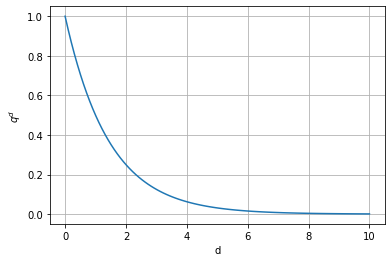

In [4]:
dots = np.linspace(0, 10, 100)
q = 0.5
value = list(map(lambda d: q ** d, dots))

plt.xlabel('d')
plt.ylabel('$q^d$')
plt.grid()
plt.plot(dots, value);

### - $w(d) = \frac{1}{d+a}$,
брать вес $\frac{1}{d}$ по аналогии с номером соседа - неудачное решение, так как при $d = 0$ вес будет бесконечно большим, что приводит к переобучению

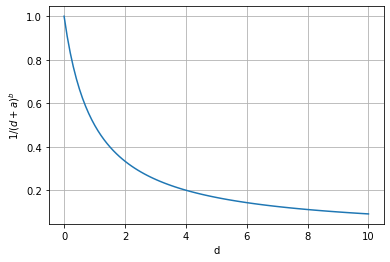

In [5]:
dots = np.linspace(0, 10, 100)
a = 1
value = list(map(lambda d: 1/(d + a), dots))

plt.xlabel('d')
plt.ylabel('$1/(d + a)^b$')
plt.grid()
plt.plot(dots, value);

Существуют и другие способы вычисления весов.

Часто перед работой по алгоритму kNN требуется проводить нормализацию признаков, так как они могут иметь разные единицы измерения, что может искажать расстояние между объектами.

В общем и целом получается, что при работе с алгоритмом kNN исследователю требуется подобрать три параметра - количество соседей k, метрика расстояния и способ вычисления весов. Для получения лучшего качества работы алгоритма эти параметры нужно подбирать на отложенной выборке или при помощи кросс-валидации.

### Реализация алгоритма kNN<a class='anchor' id='implement_knn'>

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

Загрузим один из "игрушечных" датасетов из sklearn.

In [7]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

Разделим выборку на обучающую и тестовую

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)
X_train.shape, X_test.shape

((120, 2), (30, 2))

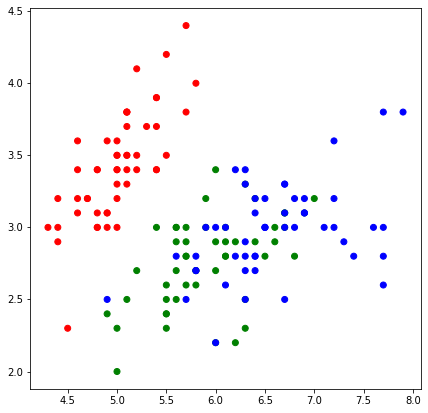

In [9]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [10]:
def e_metrics(x1, x2):
    
    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

Реализуем алгоритм поиска k ближайших соседей.

In [11]:
{class_item: 0 for class_item in set(y_train)}

{0: 0, 1: 0, 2: 0}

In [12]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

Напишем функцию для вычисления точности

In [13]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Проверим работу алгоритма при различных k

In [14]:
k = 2

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 2: 0.733


Построим график распределения классов.

In [15]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .1

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    print(np.c_[xx.ravel(), yy.ravel()].shape)

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)
    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

(2352, 2)


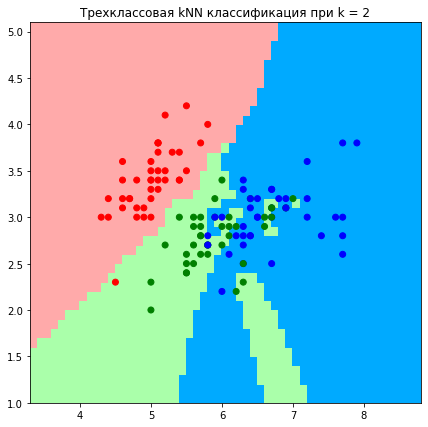

CPU times: user 12.3 s, sys: 51.3 ms, total: 12.3 s
Wall time: 13.2 s


In [16]:
%%time
get_graph(X_train, y_train, k)

In [17]:
k = 3

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 3: 0.733


(2352, 2)


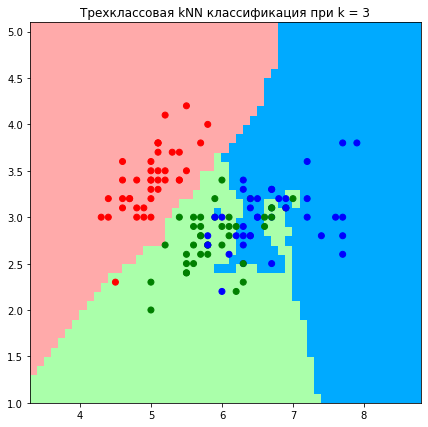

CPU times: user 15.2 s, sys: 87.9 ms, total: 15.3 s
Wall time: 15.7 s


In [18]:
%%time
get_graph(X_train, y_train, k)

In [19]:
k = 5

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5: 0.733


(2352, 2)


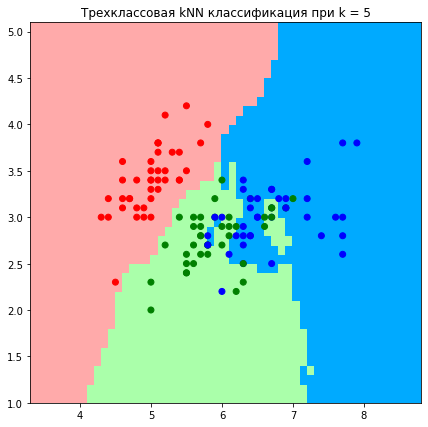

CPU times: user 14.2 s, sys: 143 ms, total: 14.3 s
Wall time: 15.2 s


In [20]:
%%time
get_graph(X_train, y_train, k)

In [21]:
k = 10

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 10: 0.767


(2352, 2)


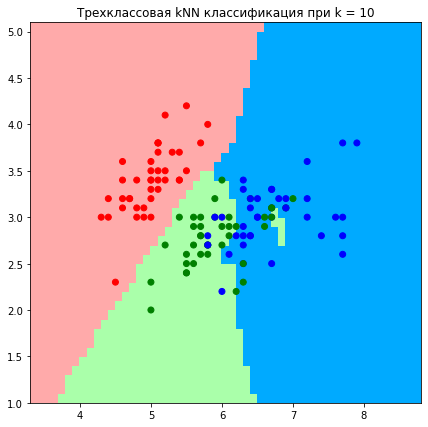

CPU times: user 13.9 s, sys: 75.5 ms, total: 14 s
Wall time: 14.5 s


In [22]:
%%time
get_graph(X_train, y_train, k)

При увеличении k мы на графиках наблюдаем, как алгоритм меньше концентрируется на выбросах, однако, точность на тестовой выборке при этом увеличивается.

Рассматриваемый метод, несмотря на положительные стороны в виде легкости интерпретации, простоты и удобства использования, обладает некоторыми минусами, в частности, он плохо работает на датасетах с большим количеством признаков.

Например, если мы имеем три объекта, при этом второй отличается от первого только значением одного признака, но значительно, а третий отличается от первого незначительно в каждом признаке, расстояния от первого объекта до второго и третьего могут совпадать. Несущественные различия в каждом признаке могут иметь большее значение, чем большое различие в одном признаке. Такое поведение в ряде случаев будет нежелательным. 


In [18]:
x = np.zeros((2000))
y = np.zeros((2000))
y[2] = 100

e_metrics(x, y)

100.0

In [19]:
x = np.zeros((2000))
z = np.ones((2000))
e_metrics(x, z)

44.721359549995796

Второй пример - случай, когда количество признаком сравнимо с количеством объектов. В этом случае может возникнуть ситуация, когда расстояния между любыми двумя объектами почти одинаковы. В двумерном пространстве (на плоскости) три точки могут располагаться по вершинам равностороннего треугольника, при этом расстояния между ними будут равны; в трехмерном пространстве то же самое справедливо для четырех точек на вершинах тетраэдра - расстояние между любыми двумя точками будет одинаково. В общем случае это означает, что в $n$-мерном пространстве можно выбрать $n+1$ точку так, чтобы расстояние между любыми двумя точками было одинаковым.

<img src='images/trtet.png' width=400px>

Третий пример - так называемое "проклятие размерности". Суть его заключается в том, что при наличии $n$ бинарных признаков в пространстве признаков будет возможно $2^{n}$ различных объектов вида $x = (0,1,0,0,1,...,1)$, и размер обучающей выборки, необходимый, чтобы описать все пространство объектов (то есть все возможные комбинации таких признаков) также будет порядка $2^{n}$. Чтобы покрыть не все пространство, а долю объектов $\alpha$ (то есть долю объема $\alpha$) нужно будет описать гиперкуб с длиной ребра $e_{p} = \alpha^{n}$. Например, в 10-мерном пространстве признаков чтобы покрыть 1% объема нужно взять гиперкуб с длиной $e_{10}(0,01) = 0.63$, то есть взять окрестность длиной больше половины ребра исходного пространства. Чем больше признаков, тем меньше будет область, которая покрывается во время поиска на заданном расстоянии. Таким образом, при сохранении требований по точности нахождения объекта в пространстве, количество требуемых данных для этого при увеличении количества признаков растет экспоненциально (подробнее про это явление см. в доп. материалах).

Рассмотрим для примера куб с ребром 1 и в нем рассмотрим куб с ребром $\frac{1}{2}$. Посмотрим, какую долю он будет занимать в первом кубе.
<img src='images/curse.png' width=400px>

## Обучение без учителя. Кластеризация. K-means<a class='anchor' id='unsupervised'>

До этого мы рассматривали методы обучения с учителем, то есть задачи, в которых изначально есть размеченная обучающая выборка данных с известными ответами на них и тестовая выборка, на которой проверяется качество алгоритма. В этом разделе речь пойдет об _обучении без учителя (unsupervised learning)_ - случае, когда в роли обучающей выборки выступает просто набор объектов $x_{1},...,x_{l}$, и он же выступает в роли тестовой выборки, а задача состоит в проставлении меток $y_{1},...,y_{l}$ так, что бы объекты с одной и той же меткой были похожи, а с разными - нет. То есть все объекты в пространстве признаков нужно разделить на группы, найти структуру в данных. Это и называется _кластеризацией_. Если раньше мы имели примеры ответов $y$, то сейчас их нет, и нужно строить свои отображения $x \rightarrow y$, отвечающие некоторым свойствам, например, тому, что похожие объекты отображаются в одну метку, а непохожие - в разные. По-простому задачу кластеризации можно сформулировать так: имеется множество точек, которые скапливаются в кластера, нужно найти возможность относить точки к тому или иному кластеру и предсказывать, в какой кластер попадет новая точка.

<img src='images/clusters.png' width=600px>

Примерами кластеризации может быть группирование новостей по темам, музыки по жанрам, клиентов по типу поведения и т.д.

Логично возникает вопрос, как измерять качество кластеризации. Есть большое количество инструментов оценки качества кластеризации, они разделяются на _внутренние_ (основанные только на свойствах выборки и кластеров) и _внешние_ (использующие данные об истинном распределении объектов по кластерам, если оно известно).

## Внутренние метрики <a class='anchor' id='in'>

- Внутрикластерное расстояние (также называется компактностью кластеров, cluster cohesion): $$\sum_{k=1}^{K}\sum_{i=1}^{l}[a(x_{i})=k]\rho(x_{i}, c_{k}),$$ где $K$ - количество кластеров, $c_{k}$ - центр кластера. Этот функционал нужно минимизировать, так как в идеальном случае все объекты в одном кластере одинаковы, и расстояние между ними равно нулю.


- Межкластерное расстояние (отделимость кластеров, cluster separation): $$\sum_{i,j=1}^{l}[a(x_{i}) \neq a(x_{j})]\rho(x_{i}, x_{j}).$$ Этот функционал наоборот нужно максимизировать, так как объекты из разных кластеров должны максимально различаться, то есть иметь максимальное расстояние между собой.


- Часто используются те же формулы, но включающие не расстояние ρ, а его квадрат, получая квадратичное внутрикластерное и межкластерное расстояние:

    $$\sum_{k=1}^{K}\sum_{i=1}^{l}[a(x_{i})=k]\rho^{2}(x_{i}, c_{k}),$$
    $$\sum_{i,j=1}^{l}[a(x_{i}) \neq a(x_{j})]\rho^{2}(x_{i}, x_{j}).$$


- Среднее внутрикластерное расстояние (среднее расстояние внутри каждого кластера, просуммированное по всем кластерам) и среднее межкластерное расстояние (минимизируется и максимизируется, соответственно, по аналогии с двумя первыми функционалами):

    $$\sum_{k=1}^{K}\frac{1}{|k|}\sum_{i=1}^{l}[a(x_{i})=k]\rho(x_{i}, c_{k}),$$
    $$\frac{1}{K}\sum_{i,j=1}^{l}[a(x_{i}) \neq a(x_{j})]\rho(x_{i}, x_{j}),$$ где $|k|$ - количество элементов в кластере под номером $k$.

- По аналогии с квадратичным внутрикластерным и межкластерным расстоянием - среднее квадратичное внутрикластерное и межкластерное расстояние.

    $$\sum_{k=1}^{K}\frac{1}{|k|}\sum_{i=1}^{l}[a(x_{i})=k]\rho^{2}(x_{i}, c_{k}),$$
    $$\frac{1}{K}\sum_{i,j=1}^{l}[a(x_{i}) \neq a(x_{j})]\rho^{2}(x_{i}, x_{j}).$$ 
    
- Силуэт (Silhouette) является мерой того, насколько объект похож на свой собственный кластер (сплоченность) по сравнению с другими кластерами (разделение).
$$s = \frac{1}{n}\sum{\frac{b-a}{max(a, b)},}$$
где а — среднее расстояние от данного объекта до объектов из того же кластера, b — среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект)

<img src='images/silhouette.png' width=400>




## **Внешние метрики** <a class='anchor' id='out'>
Эти метрики используются, если есть дополнительные знания о кластеризуемой выборке, например, известно истинное распределение по кластерам. Задачу можно рассматривать как задачу многоклассовой классификации с использованием соответствующих метрик. В этом случае примерами могут быть:

In [ ]:
true = [0, 0, 0, 1, 1, 1]
pred = [0, 0, 0, 1, 1, 1]


true = [0, 0, 0, 1, 1, 1]
pred = [1, 1, 1, 0, 0, 0]

### - Homogenity, Completeness, V-measure

Определяются с использованием функций энтропии
K — результат кластеризации, C — истинное разбиение выборки на классы

**Гомогенность** измеряет, насколько каждый кластер состоит из объектов одного класса.


**Полнота** измеряет, насколько объекты одного класса относятся к одному кластеру.


**V-мера**

Для учёта гомогенности и полноты одновременно вводится V-мера, как их среднее гармоническое:

$$v = 2\frac{hc}{h+c}$$

Принимают значения в диапазоне [0,1]

**Гомогенность**


$$h = 1 - \frac{H(C|K)}{H(C)}$$

$$H(C|K) = - \sum_{j=1}^m{\sum_{i=1}^n{p(c_i, k_j)\log \frac{p(c_i, k_j)}{p(k_i)}}}$$

$$H(C) = - \sum_{i=1}^n{p(c_i)\log p(c_i)}$$


In [16]:
true = np.array([0, 0, 0, 1, 1, 1])
pred = np.array([0, 1, 2, 3, 4, 5])

In [17]:
from sklearn.metrics.cluster import contingency_matrix
cm = contingency_matrix(true, pred)

In [18]:
cm

array([[1, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 1]])

In [19]:
h_c_k = 0
for j in range(cm.shape[1]):
    for i in range(cm.shape[0]):
        size = np.sum(cm)
        p_c_k = cm[i][j] / size
        p_k = np.sum(cm[:, j]) / size
        if p_c_k == 0:
            continue
        h_c_k += p_c_k * np.log2(p_c_k / p_k)
        
h_c = 0
for i in range(cm.shape[0]):
    size = np.sum(cm)
    p_c = np.sum(cm[i]) / size

    h_c += p_c * np.log2(p_c)
        
h = 1 - h_c_k / h_c
h

1.0

**Полнота**


$$c = 1 - \frac{H(K|C)}{H(K)}$$

$$H(K|C) = - \sum_{j=1}^m{\sum_{i=1}^n{p(k_i, c_j)\log \frac{p(k_i, c_j)}{p(c_i)}}}$$

$$H(K) = - \sum_{i=1}^n{p(k_i)\log p(k_i)}$$

In [25]:
true = np.array([0, 0, 0, 1, 1, 1])
pred = np.array([0, 1, 2, 3, 4, 5])

In [26]:
cm = contingency_matrix(true, pred)
cm

array([[1, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 1]])

In [27]:
h_k_c = 0
for j in range(cm.shape[0]):
    for i in range(cm.shape[1]):
        size = np.sum(cm)
        p_k_c = cm[j][i] / size
        p_c = np.sum(cm[j]) / size
        
        if p_k_c == 0:
            continue
        h_k_c += p_k_c * np.log2((p_k_c / p_c) + 1e-18)
        
h_k = 0
for i in range(cm.shape[1]):
    size = np.sum(cm)
    p_k = np.sum(cm[:, i]) / size

    h_k += p_k * np.log2(p_k + 1e-18)
    
    
h_k += 1e-18
        
c = 1 - h_k_c/ h_k
c

0.3868528072345415

**V-мера**

$$v = 2\frac{hc}{h+c}$$


In [28]:
2 * h * c / (h + c)

0.5578858913022595

In [29]:
from sklearn.metrics.cluster import homogeneity_completeness_v_measure
homogeneity_completeness_v_measure(true, pred)

(0.9999999999999993, 0.3868528072345413, 0.5578858913022592)

Про другие внутренние и внешние метрики качества кластеризации можно почитать в дополнительных материалах.

### Алгоритм K-means (K-средних)<a class='anchor' id='kmeans'>

<img src='images/kmeans.png' width=800px>

Одним из самых простых и популярных алгоритмов кластеризации является алгоритм _K-means (K-средних)_. Заключается он в следующих шагах:

1. Выбрать количество кластеров $k$, на которые будут делиться данные.


2. Случайным образом выбрать в пространстве данных $k$ точек $c_{k}$ (центроидов) - центров будущих кластеров.


3. Для каждой точки из выборки посчитать, к какому из центроидов она ближе.


4. Переместить каждый центроид в центр выборки, отнесенной к этому центроиду, определив его как среднее арифметическое всех точек кластера:

$$c_{k} = \frac{\sum_{i=1}^{l}[a(x_{i})=k]x_{i}}{\sum_{i=1}^{l}[a(x_{i}) = k]}.$$


5. Повторить шаги 3-4 до сходимости алгоритма (обычно это оценивается по величине смещения центроида после каждого шага - сходимость означает непревышение смещения какого-то заданного значения).

Результат работы алгоритма значительно зависит от начального выбора центроидов. Существует много методик их выбора, наиболее удачным из которых считается k-means++. Он заключается в последовательном выборе начальных приближений так, что вероятность выбрать в качестве центроида следующую точку пропорциональна квадрату расстояния от нее до ближайшего центроида.

Проблемой метода также является необходимость знать число кластеров, на которые будет делиться выборка. В случае, когда это число неизвестно, вариантом ее решения может быть последовательная кластеризация на разное число кластеров (например, от 1 до 10) с последующим анализом качества работы алгоритма, например, по сумме квадратов внутрикластерных расстояний     $$\sum_{k=1}^{K}\sum_{i=1}^{l}[a(x_{i})=k]\rho^{2}(x_{i}, c_{k}),$$ - выбирается такое число кластеров, начиная с которого при увеличении количества кластеров функционал падает незначительно.

<img src='images/elbow.png'>

Сделаем простую реализацию алгоритма K-means своими руками на Python.

Вначале сгенерируем три облака точек с помощью инструментов `sklearn`.

In [30]:
from sklearn.datasets import make_blobs, make_moons

X, y = make_blobs(n_samples=100, random_state=1)
# X, y = make_moons(n_samples=50, noise=0.02, random_state=1)

Изобразим точки на графике.

In [31]:
import matplotlib.pyplot as plt

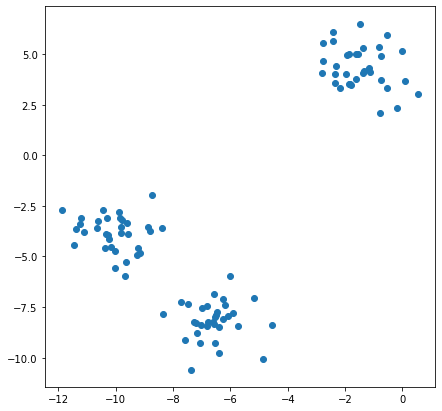

In [32]:
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1]);

В качестве метрики расстояния будем использовать евклидово расстояние, функция для которого была написана ранее. В качестве центроидов выберем первые k элементов датасета. Реализуем основной цикл алгоритма.

In [33]:
def e_metrics(x1, x2):
    
    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

In [34]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для кластеризации
    clusters = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # кластеризуем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            cluster = distances.index(min(distances))
            clusters[cluster].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for cluster in clusters:
            centroids[cluster] = np.mean(clusters[cluster], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.linalg.norm(centroids[centroid] - old_centroids[centroid], ord=2) > min_distance:
                optimal = False
                break
        
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, clusters

Напишем функцию для визуализации кластеров

In [35]:
def visualize(centroids, clusters):
    colors = ['r', 'g', 'b', 'orange', 'y']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for cluster_item in clusters:
        for x in clusters[cluster_item]:
            plt.scatter(x[0], x[1], color=colors[cluster_item])
            
    plt.show()

In [37]:
# определим максимальное количество итераций
max_iterations = 1

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 3

Проверим результат алгоритма после одной итерации

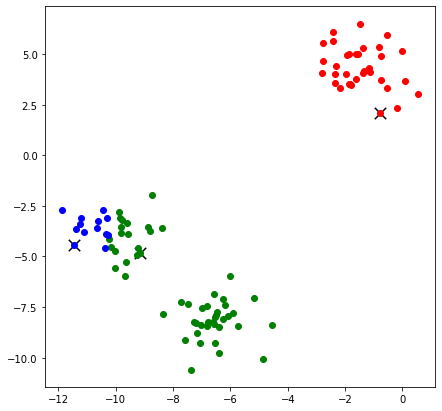

CPU times: user 2.31 s, sys: 49.2 ms, total: 2.36 s
Wall time: 2.51 s


In [38]:
%%time
centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

Проверим работу алгоритма при различном числе итераций.

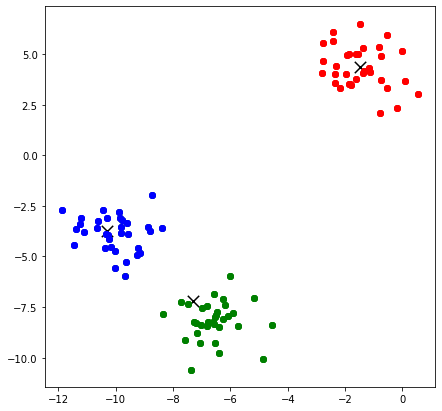

CPU times: user 7.22 s, sys: 60.6 ms, total: 7.28 s
Wall time: 7.52 s


In [39]:
%%time
max_iterations = 3

centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

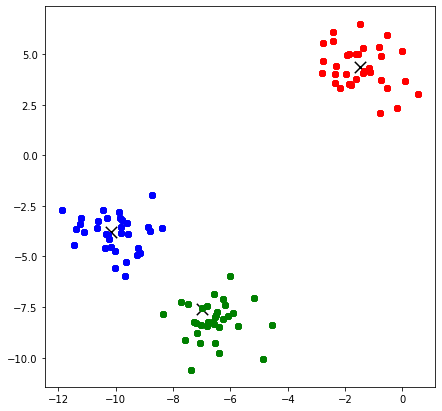

CPU times: user 11.9 s, sys: 41.8 ms, total: 12 s
Wall time: 12.4 s


In [40]:
%%time
max_iterations = 5

centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

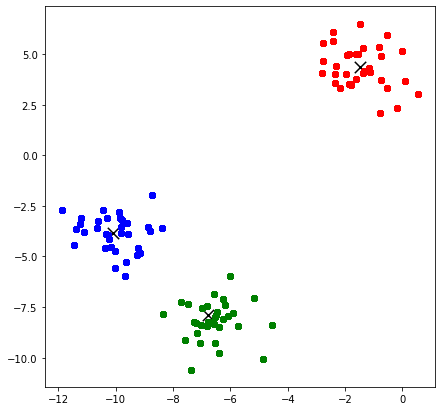

CPU times: user 25.1 s, sys: 156 ms, total: 25.3 s
Wall time: 26.1 s


In [41]:
%%time
max_iterations = 10

centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

Видно, как при увеличении количества итераций центроиды перемещаются в центр образующихся кластеров.

Как и говорилось ранее, метод K-means очень чувствителен к выбору начальных центров кластеров, и это является одним из его основных минусов, среди которых также сложность работы с разными формами кластеров (они, например, могут быть вытянутыми, образовывать фигуры и т.п.). В связи с этим существуют другие методы кластеризации, о которых можно прочитать в дополнительных материалах. Там же есть сравнение работы алгоритмов с кластерами различных форм.

## Домашнее задание<a class='anchor' id='hw'>

1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.
2. *Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).
3. *Оптимизировать код для KNN (оставить один цикл, либо обойтись без циклов вообще).

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]
X.shape

(150, 2)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)
# стратификация - одинкаковое распределение Y на тесте и на трейне
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X.shape, y.shape

((120, 2), (30, 2), (120,), (30,), (150, 2), (150,))

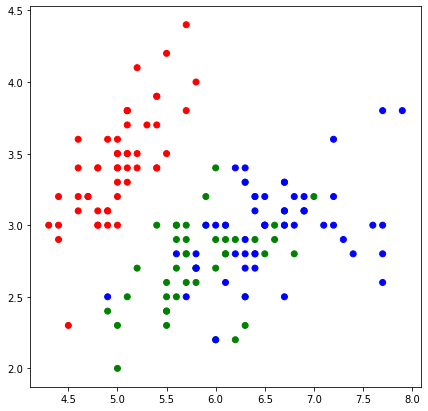

In [4]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

In [5]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
        
    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

In [6]:
def knn(x_train, y_train, x_test, k):
    answers = []
    for x in x_test: # x = [2.5, 4.6]
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до каждого объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))  # массив [расст-е, ответ],...
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}  # {0:0, 1:0, 2:0}

        # Сортируем список по удалённости и среди первых k элементов подсчитаем частоту появления разных классов
        n = 1
        q = 0.9
        for d in sorted(test_distances)[0:k]:  # sorted(test_distances)[0:k] = [(0.09, 2), (0.14, 2)]
            # d = (0.141, 2) - расст-е, класс
#             print(d)
            weight = q ** n
#             print(f'weight={weight}')
            classes[d[1]] += weight  # classes={0: 0, 1: 0, 2: 1.0} - {класс: вес}
#             print(f'classes={classes}')
            n += 1
        
#         print(f'classes all={classes}')
#         print(f'classes sorted={sorted(classes, key=classes.get)} classes_last_elem={sorted(classes, key=classes.get)[-1]}')
        
        # Записываем в список класс с наибольшей суммой весов
        answers.append(sorted(classes, key=classes.get)[-1])
#         print('answers=', answers)
    return answers

In [7]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [8]:
k = 2

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.5f}')

Точность алгоритма при k = 2: 0.70000


In [9]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02 # шаг с которым берутся точки

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    # Через meshgrid создается сетка из аргументов, матрица, с координатами всех точек
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    print(np.c_[xx.ravel(), yy.ravel()].shape)

    # Получим предсказания для всех точек
    # ravel преобразовывает матрицу в 1-мерный вектор, по возможности без создания копии
    # Например: np.ravel(np.array([[1, 2, 3], [4, 5, 6]])) >>> array([1, 2, 3, 4, 5, 6])
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)
    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

(58800, 2)


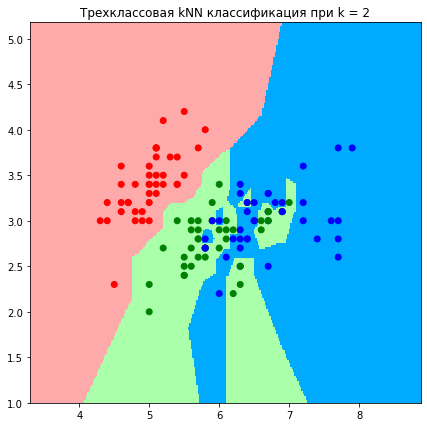

CPU times: user 5min 20s, sys: 9.58 s, total: 5min 30s
Wall time: 8min 44s


In [10]:
%%time
get_graph(X_train, y_train, k)

In [11]:
k = 3

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.5f}')

Точность алгоритма при k = 3: 0.73333


(58800, 2)


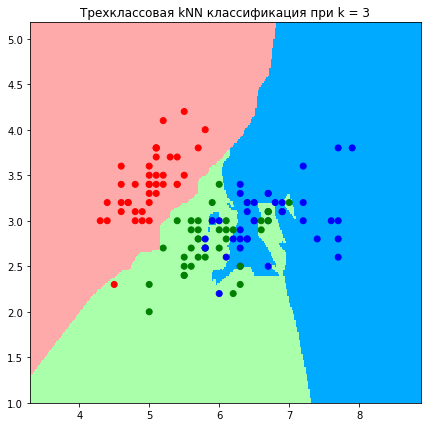

CPU times: user 3min 58s, sys: 4.79 s, total: 4min 3s
Wall time: 4min 56s


In [12]:
%%time
get_graph(X_train, y_train, k)

In [13]:
k = 5

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.5f}')

Точность алгоритма при k = 5: 0.73333


(58800, 2)


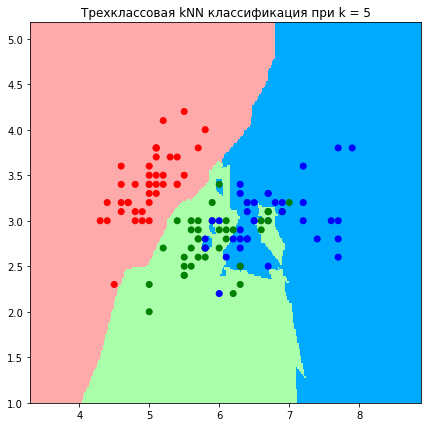

CPU times: user 3min 50s, sys: 4.23 s, total: 3min 54s
Wall time: 4min 33s


In [14]:
%%time
get_graph(X_train, y_train, k)

In [15]:
k = 10

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.5f}')

Точность алгоритма при k = 10: 0.73333


(58800, 2)


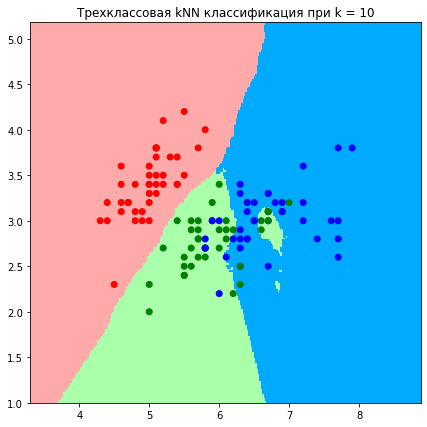

CPU times: user 3min 35s, sys: 3.57 s, total: 3min 38s
Wall time: 4min 4s


In [16]:
%%time
get_graph(X_train, y_train, k)

*Проект: 
1. https://www.kaggle.com/c/gb-tutors-expected-math-exam-results регрессия
1. https://www.kaggle.com/c/gb-choose-tutors классификация

## Дополнительные матриалы

1. Факторный, дискриминантный и кластерный анализ: Пер. с англ./Дж.-О. Ким, Ч. У. Мьюллер, У. Р. Клекка и др.; Под ред. И. С. Енюкова. — М.: Финансы и статистика, 1989.— 215 с.
2. [Об использовании мер сходства при анализе документации](http://ceur-ws.org/Vol-803/paper18.pdf)
3. [KNN Algorithm](https://medium.com/datadriveninvestor/knn-algorithm-and-implementation-from-scratch-b9f9b739c28f)
4. [Проклятие размерности](http://www.machinelearning.ru/wiki/index.php?title=%D0%9F%D1%80%D0%BE%D0%BA%D0%BB%D1%8F%D1%82%D0%B8%D0%B5_%D1%80%D0%B0%D0%B7%D0%BC%D0%B5%D1%80%D0%BD%D0%BE%D1%81%D1%82%D0%B8); ([Иллюстрация](https://www.youtube.com/watch?v=R2hQIJb0Lis))
5. [Оценка качества кластеризации](http://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8)
6. [Обзор алгоритмов кластеризации данных](https://habr.com/ru/post/101338/)
7. [Работа алгоритмов кластеризации на классах разной формы](https://scikit-learn.org/stable/modules/clustering.html)

## Summary

__kNN__
* Метрический алгоритм классификации по "ближайшим соседям"
* Разновидности: ближайший сосед, k ближайших соседей, k взвешанных ближайших соседей
* Алгоритм интерпретируем
* Проблемы и их решения
    * Выбор метрики __->__ нет единого алгоритма, позволяющего выбрать метрику, поэтому используют что-то из "стандартного" (например, Евклидова)
    * Выбор числа соседей k __->__ подбор на основании кросс-валидации
    * Много признаков - "проклятие размерности" __->__ предварительный отбор признаков (feature selection)

__k-means__
* Кластеризует неразмеченные объекты, помогая найти структуру в данных
* Является метрическим алгоритмом
* Можно использовать для генерации нового признака - номера кластера
* Проблемы и их решения
    * Алгоритм чувствителен к выбору начальных центров кластеров __->__ как вариант, на начальном этапе принимать в качестве центров самые отдаленные точки
    * Необходимо заранее знать количество кластеров __->__ выбор исходя из природы данных, либо оценка исходя из распределений признаков или 2D/3D представления объектов (PCA, TSNE)
    * Не гарантируется достижение глобального минимума суммарного квадратичного отклонения, а только одного из локальных минимумов (пример на картинке ниже) __->__ инициализировать начальные центры не случайно
    
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/7c/K-means_convergence_to_a_local_minimum.png/1920px-K-means_convergence_to_a_local_minimum.png" style="width: 1000px;">

### Определения
*Метрические алгоритмы*

**Метрический алгоритм** — алгоритм машинного обучения, основанный на вычислении оценок сходства между объектами.

Три аксиомы, которые должны удовлетворяться, чтобы функция считалась метрикой:

1. $\rho(x, y) \geq 0, \rho(x, y) = 0 \Leftrightarrow x = y;$
2. $\rho(x, y) = \rho (y, x);$
3. $\rho(x, y) \leq \rho(x, z) + \rho(z, y).$

**Косинусное сходство (косинусная мера)**:

$$\text{cos}\theta = \frac{\left \langle x, y \right \rangle}{||x||\cdot||y||} = \frac{\sum_{i=1}^{n}x_{i}y_{i}}{\sqrt{\sum_{i=1}^{n}x_{i}^{2}}\sqrt{\sum_{i=1}^{n}y_{i}^{2}}}.$$
**Косинусное расстояние**:

$$\rho_{cos}(x, y) = 1 - \text{cos}\theta = 1 - \frac{\sum_{i=1}^{n}x_{i}y_{i}}{\sqrt{\sum_{i=1}^{n}x_{i}^{2}}\sqrt{\sum_{i=1}^{n}y_{i}^{2}}}.$$

___________

*Внутренние метрики качества кластеризации*

**Silhouette** —- является мерой того, насколько объект похож на свой собственный кластер (сплоченность) по сравнению с другими кластерами (разделение).

$$s = \frac{1}{n}\sum{\frac{b-a}{max(a, b)}}$$
- а — среднее расстояние от данного объекта до объектов из того же кластера
- b — среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект)

___________
*Внешние метрики качества кластеризации*

**Rand Index (RI)** — Доля объектов, для которых разбиения (исходное и полученное в результате кластеризации) "согласованы".
 $$Rand = \frac{a+b}{a+b+c+d} = \frac{a+b}{{n \choose 2 }}, где$$
 
 $ {n \choose 2} = {\frac{n(n-1)}{2}}$

Здесь количество пар объектов $(x_{i}.x_{j})$, 
 - а - принадлежат одному кластеру и одному классу,
 - b - принадлежат разным кластерам и разным классам,
 - c - принадлежат разным кластерам, но одному классу,
 - d - принадлежат одному кластеру, но разным классам.

**Adjusted Rand Index (ARI)** — Нормированная доля объектов, для которых разбиения (исходное и полученное в результате кластеризации) "согласованы".


$$ARI= \frac{RI - \text{Expected_RI}}{max(RI) - \text{Expected_RI}} =  {\frac {2 * (a*d - b*c)}{(a+b) * (b+d) + (a + c) * (c + d)}}$$

**Гомогенность** измеряет, насколько каждый кластер состоит из объектов одного класса.

$$h = 1 - \frac{H(C|K)}{H(C)}$$

**Полнота** измеряет, насколько объекты одного класса относятся к одному кластеру.

$$c = 1 - \frac{H(K|C)}{H(K)}$$

**V-мера**

Для учёта гомогенности и полноты одновременно вводится V-мера, как их среднее гармоническое:

$$v = 2\frac{hc}{h+c}$$
